<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Анализ токсичности комментариев с GloVe

Ускорить модерацию комментариев в сообществе, автоматизировав оценку их токсичности.
Обучить модель классифицировать комментарии на позитивные и негативные.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [6]:
import numpy as np
import pandas as pd
import os

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K
from keras import layers, Input
from keras.models import Model

In [7]:
_path = ''
df = pd.read_csv(_path + '/datasets/toxic_comments.csv')
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


На диаграмме ниже видно, что в выборке преобладают нетоксичные комментарии.

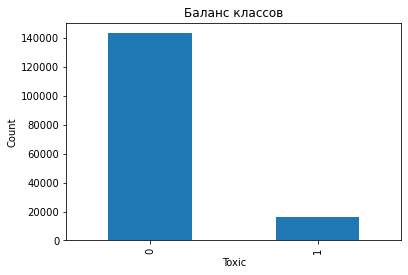

In [9]:
df['toxic'].value_counts().plot(kind='bar')
plt.title('Баланс классов')
plt.xlabel('Toxic')
plt.ylabel('Count');

Удалим стоп-слова из комментариев.

In [10]:
stop_words = set(stopwords.words('english'))

def delete_stop_words(row):
    text = row['text']
    tokens = word_tokenize(text, language="english")
    filtered_tokens = []
    for token in tokens:
        if token not in stop_words:
            filtered_tokens.append(token)
    return ' '.join(filtered_tokens)

In [11]:
df['text'] = df.apply(delete_stop_words, axis=1)

Введем новые списковые переменные.

In [12]:
texts = df['text'].tolist()
labels = df['toxic'].tolist()

Токенизируем текст с ограничениями:
* Каждый комментарий ограничен 150 словами;
* В словаре будут 10.000 самых часто встречающихся слов.

In [13]:
maxlen = 150 # Отсечение остатка отзывов после 100-го слова
max_words = 10000 # Рассмотрение только 10 000 наиболее часто используемых слов
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 194213 unique tokens.
Shape of data tensor: (159571, 150)
Shape of label tensor: (159571,)


**Вывод**

Классы сильно дисбалансированы, но можно будет стратифицировать выборки.    
Были удалены стоп-слова.     
Текст был токенизирован с ограничениями:
* Каждый комментарий ограничен 150 словами;
* В словаре будут 10.000 самых часто встречающихся слов.

## Обучение

Разобьем выборку на обучающую и валидационную в соотношении 9:1 (стратифицируя по целевому признаку)

In [14]:
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.1, random_state=12345, stratify=labels)

Вместо BERT я решил попробовать модель `GloVe`. Была взята преодобученная модель с размерностью векторного пространства признаков равной 100.

Модель GloVe похожа на Word2vec, тоже создает эмбединг векторы для слов, но сильно упирает на совместную статистику встречаемости слов.      

Отличие модели GloVe от Bert в том, что она является контекстно независимой и генерирует один эмбединг вектор, а Bert может генерировать различные эмбединги для слова в зависимости от его контекста. 

Сохраним в словарь `embeddings_index` векторы слов, полученные с помощью предобученной модели GloVe.

In [15]:
glove_dir = _path + '/datasets/glove.6B'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Создание матрицы `embedding`: создаем матрицу `embedding_matrix` с формой (10.000, 100), где каждая строчка - это одно уникальное слова из словаря, а столбцы этой строчки образуют вектор данного слова.    
Заполнение матрицы происходит при проходе по циклу и поиска нужно слова в словаре `embeddings_index`.

In [16]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Для расчета F1-меры во время обучения, необходимо также рассчитать `recall` и `precision`. Объявим три функции, которые будут рассчитывать полноту, точность или F1-меру при передаче, в качестве параметров, истинные ответы и предсказания модели.

In [17]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Небольшая нейронная сеть. В основе LSTM слои и 3 ветви. Идея получить то же, что делает сеть `Inception` для сверточных нейросетей, только с рекуррентными. 

Каждая ветвь обладает различным уровнем нейронов и слоев, чтобы (*в теории*) улавливать признаки различного уровня абстракции. Каждая ветвь заканчивается слоем прореживания, чтобы уменьшить эффект переобучаемости и увеличить репрезентативность результатов.

In [18]:
text_input = Input(shape=(None, ), dtype='int32', name='texts')
embedded_posts = layers.Embedding(max_words, embedding_dim)(text_input)

x_1 = layers.LSTM(16)(embedded_posts)
x_1 = layers.Dropout(0.5)(x_1)


x_2 = layers.LSTM(32, return_sequences=True)(embedded_posts)
x_2 = layers.LSTM(16)(x_2)
x_2 = layers.Dropout(0.5)(x_2)


x_3 = layers.LSTM(128, return_sequences=True)(embedded_posts)
x_3 = layers.LSTM(64, return_sequences=True)(x_3)
x_3 = layers.LSTM(32)(x_3)
x_3 = layers.Dropout(0.5)(x_3)

concatted = layers.concatenate([x_1, x_2, x_3], axis=-1)
product_prediction = layers.Dense(1, name='product', activation='sigmoid')(concatted)
model = Model(text_input, product_prediction)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
texts (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    1000000     texts[0][0]                      
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, None, 128)    117248      embedding[0][0]                  
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, None, 32)     17024       embedding[0][0]                  
______________________________________________________________________________________________

Веса, полученные от предобученной модели GloVe изменять не нужно, поэтому их нужно заморозить.

In [19]:
model.layers[1].set_weights([embedding_matrix])
model.layers[1].trainable = False

Обучение будет происходит на протяжении 4 эпох, пакетам по 128 комментариев.

In [20]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[f1_m])
history = model.fit(x_train,
                    y_train,
                    epochs=4,
                    batch_size=128,
                    validation_data=(x_val, y_val))

Epoch 1/4
1122/1122 [==============================] - 513s 451ms/step - loss: 0.1997 - f1_m: 0.5311 - val_loss: 0.1215 - val_f1_m: 0.7492
Epoch 2/4
1122/1122 [==============================] - 500s 445ms/step - loss: 0.1245 - f1_m: 0.7495 - val_loss: 0.1161 - val_f1_m: 0.7686
Epoch 3/4
1122/1122 [==============================] - 514s 458ms/step - loss: 0.1121 - f1_m: 0.7786 - val_loss: 0.1119 - val_f1_m: 0.7670
Epoch 4/4
1122/1122 [==============================] - 532s 474ms/step - loss: 0.1040 - f1_m: 0.7962 - val_loss: 0.1091 - val_f1_m: 0.7892


Теперь определим лучшее значение порога для решения о присуждении комментарию метки токсичности или нет, делать это будем на трейне:    

Метод предикт вернет для каждого образца число от 0 до 1, который можно интерпретировать как вероятность принадлежности модели к классу `toxic`. Мы можем выбрать такое значение вероятности, которое будет достаточным для присвоения образцу метки `toxic`. 

Метрикой лучшего значения для порога будет F1-мера.

Данное действие проводится на трейне, чтобы внутрь модели не просачивались информация о валидационной выборке.

In [21]:
prediction = model.predict(x_train)

max_f1 = 0
best_del = 0
for i in np.arange(0, 1, 0.05):
    _pred = np.where(prediction < i, 0, 1)
    _f1 = f1_score(y_train, _pred)
    
    if(_f1 > max_f1):
        max_f1 = _f1
        best_del = i
    
print(f'Best F1 on train = {max_f1} if delimiter = {best_del}')

Best F1 on train = 0.8274380638693971 if delimiter = 0.5


Теперь можно вычислить `F1-меру`, используя порог, полученный на предыдущем шаге. 

In [22]:
prediction_val = model.predict(x_val)
prediction_val = np.where(prediction_val < best_del, 0, 1)
print(f'F1 on valid = {f1_score(y_val, prediction_val)}')

F1 on valid = 0.7979240999026922


`F1-мера` выше необходимого порога.

Проверим модель на адекватность.

In [23]:
print(f'Точность = {accuracy_score(y_val, prediction_val):.2%}')
print(f'Точность константной модели = {1-(y_val.sum()/len(y_val)):.2%}')

Точность = 96.10%
Точность константной модели = 89.83%


Точность конечной модели выше, чем у константной, модель можно считать адекватной.

## Выводы

Для создания модели оценки токсичности комментария были использованы модели Word2vec и GloVe, а так же рекуррентная нейронная сеть, основанная на слое с долгой-краткосрочной памятью. В выборке виден сильный дисбаланс классов в пользу нетоксичных комментариев. Однако, выборка достаточная большая, чтобы обойтись без создания мнимых образцов или бутстрепинга.    
Конечная модель удовлетворяет заданным требованиям и проходит проверку на адекватность.